# Анализ данных в задаче кредитного скоринга

Для выполнения этого задания вам понадобятся данные о кредитных историях клиентов одного из банков. Поля в предоставляемых данных имеют следующий смысл: 

+    LIMIT_BAL:  размер кредитного лимита (в том числе и на семью клиента)
+    SEX: пол клиента (1 = мужской, 2 = женский )
+    EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).
+    MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных). 
+    AGE: возраст в годах
+    PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)
+    BILL_AMT1 - BILL_AMT6:  задолженность,  BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь 
+    PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре 
+    default - индикатор невозврата денежных средств

### Review criteria

1.  Выполнение каждого пункта задания должно начинаться с графика с данными, которые вы собираетесь анализировать. Еще лучше, если вы разложите графики анализируемого фактора по переменной (default), на которую хотите изучить влияние этого фактора, и проинтерпретируете отличия в полученных распределениях.
2.  При использовании статистических критериев необходимо убедиться в том, что условия их применимости выполняются. Например, если вы видите, что данные бинарные, то не нужно применять критерий Стьюдента.
3.  При каждом использовании любого критерия необходимо указать, какая проверяется гипотеза, против какой альтернативы, чему равен достигаемый уровень значимости, принимается или отвергается нулевая гипотеза на уровне значимости 0.05. Если задача позволяет, нужно оценить размер эффекта и предположить, имеет ли этот результат практическую значимость. 
4.  Выполненное задание необходимо представить в ipython-ноутбука.



In [1]:
import pandas as pd
import numpy as mp
import scipy
import itertools

from scipy import stats
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.weightstats import zconfint
from statsmodels.stats.weightstats import *

import matplotlib.pyplot as plt
import seaborn as sns
%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv("credit_card_default_analysis.csv")

In [3]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## Задание 1
Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы:   a)  о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки  b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних.  Значимы ли полученные результаты с практической точки зрения ?

In [4]:
def_0 = data[data['default']  == 0].LIMIT_BAL
def_1 = data[data['default']  == 1].LIMIT_BAL

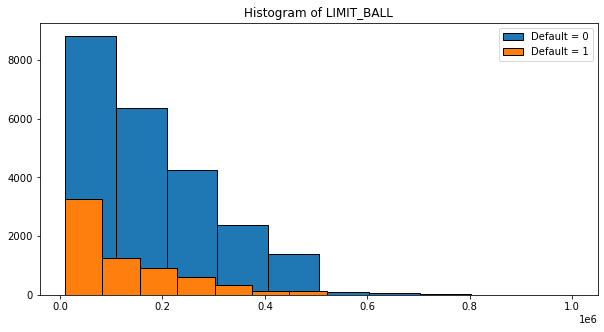

In [5]:
plt.figure(1, figsize=(10,5))

plt.title('Histogram of LIMIT_BALL')
plt.hist(def_0, edgecolor='k', label='Default = 0')
plt.hist(def_1, edgecolor='k', label='Default = 1')
plt.legend()

Проверим гипотезу о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки 

In [6]:
print('Median LIMIT_BAL for default = 0: %.0f' % def_0.median())
print('Median LIMIT_BAL for default = 1: %.0f' % def_1.median())

Median LIMIT_BAL for default = 0: 150000
Median LIMIT_BAL for default = 1: 90000


In [7]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

Интервальная оценка медианы c помощью бутстрепа

In [8]:
np.random.seed(0)

def0_median_scores = list(map(np.median, get_bootstrap_samples(def_0.values, 1000)))
def1_median_scores = list(map(np.median, get_bootstrap_samples(def_1.values, 1000)))

print("95% confidence interval for credit limit with default = 1:",  stat_intervals(def0_median_scores, 0.05))
print("95% confidence interval for credit limit with default = 0:",  stat_intervals(def1_median_scores, 0.05))

95% confidence interval for credit limit with default = 1: [150000. 150000.]
95% confidence interval for credit limit with default = 0: [80000. 90000.]


Проверим гипотезу о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних
### Перестановочный критерий
$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [9]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

In [10]:
def get_random_combinations(n1, n2, max_combinations):
    index = np.arange(n1 + n2)
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [11]:
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

In [12]:
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

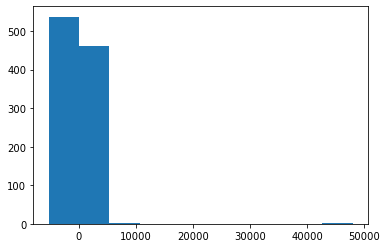

In [13]:
pylab.hist(permutation_zero_dist_ind(def_0, def_1, max_combinations = 1000))
pylab.show()

In [14]:
%%time
print ("p-value:", permutation_test(def_0, def_1, max_permutations = 1000))

p-value: 0.001
Wall time: 16.6 s


### Ранговый критерий Манна-Уитни

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [15]:
stats.mannwhitneyu(def_0, def_1)

MannwhitneyuResult(statistic=59257217.5, pvalue=6.127742909111652e-190)

## Задание 2
Пол (SEX): Проверьте гипотезу о том,  что гендерный состав  группы людей вернувших и не вернувших кредит отличается.  Хорошо, если вы предоставите несколько различных решений  этой задачи (с помощью доверительного интервала и подходящего статистического критерия)

In [19]:
male_data = data.default.loc[data.SEX == 1]
female_data = data.default.loc[data.SEX ==2]

In [20]:
male_data.describe()

count    11888.000000
mean         0.241672
std          0.428115
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: default, dtype: float64

In [21]:
female_data.describe()

count    18112.000000
mean         0.207763
std          0.405717
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: default, dtype: float64

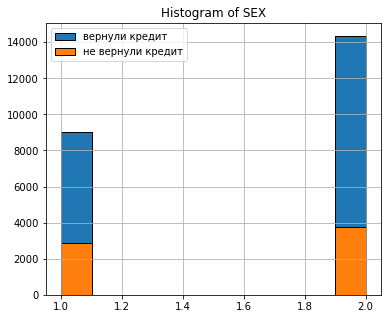

In [22]:
plt.figure(1, figsize=(6,5))
plt.title('Histogram of SEX')
plt.hist(data.SEX.loc[data.default==0], edgecolor='k', label='вернули кредит')
plt.hist(data.SEX.loc[data.default==1], edgecolor='k', label='не вернули кредит')
plt.legend()
plt.grid()

По данному графику можно сделать вывод, что женщины более склонны к невозврату кредита, чем мужчины.

### Интервальные оценки долей

In [23]:
from statsmodels.stats.proportion import proportion_confint
conf_interval_male = proportion_confint(sum(male_data), 
                                            data.shape[0],
                                            method = 'wilson')
conf_interval_female = proportion_confint(sum(female_data), 
                                            data.shape[0],
                                            method = 'wilson')
print('interval for male clients [%f, %f]' % conf_interval_male)
print('interval for female clients [%f, %f]' % conf_interval_female)

interval for male clients [0.092488, 0.099149]
interval for female clients [0.121733, 0.129229]


### Доверительный интервал для разности долей 

In [24]:
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.05):    
    z = stats.norm.ppf(1 - alpha / 2.)   
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [35]:
print("confidence interval: [%f, %f]" % proportions_confint_diff_ind(female_data, male_data))

confidence interval: [-0.043612, -0.024207]


Аналогичный вывод можно сделать, воспользовавшись интервальной оценкой двух долей.

### Z-критерий для разности долей



-    H0: гендерный состав не отличается
-    H1: гендерный состав отличается



In [26]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [27]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [34]:
print('p-value: %.20f' % proportions_diff_z_test(proportions_diff_z_stat_ind(male_data, female_data)))

p-value: 0.00000000000447286652


p-value меньше уровня значимости 0.05, поэтому гипотеза H0 отвергается. Данный результат явлется практически значимым, т.к. 6% существенная величина для банков.

## Задание 3
Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг.  Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы  разность между наблюдаемым и ожидаемым количеством человек.  Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ?  Наличие какого образования является наилучшим индикатором того, что человек  отдаст долг ? наоборт, не отдаст долг ?

+ EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).

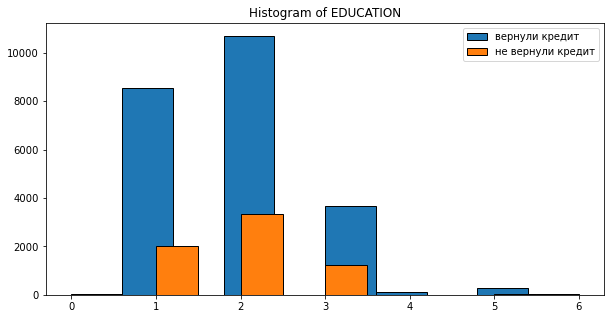

In [36]:
plt.figure(1, figsize=(10,5))
plt.title('Histogram of EDUCATION')
plt.hist(data.EDUCATION.loc[data.default == 0], edgecolor='k', label='вернули кредит')
plt.hist(data.EDUCATION.loc[data.default == 1], edgecolor='k', label='не вернули кредит')
plt.legend()

## Задание 4 
Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.
- MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).

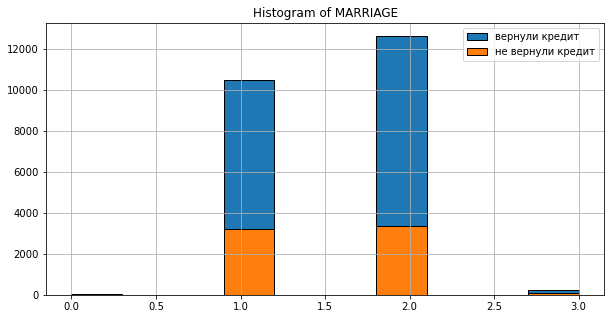

In [39]:
plt.figure(1, figsize=(10,5))
plt.title('Histogram of MARRIAGE')
plt.hist(data.MARRIAGE.loc[data.default == 0], edgecolor='k', label='вернули кредит')
plt.hist(data.MARRIAGE.loc[data.default == 1], edgecolor='k', label='не вернули кредит')
plt.legend()
plt.grid()

Замужние/женатые клиенты охотнее возвращают кредит. 

In [41]:
#samples of MARRIAGE for default = 0/1
mar = data.MARRIAGE
mar_0 = data.MARRIAGE.loc[data.default == 0]
mar_1 = data.MARRIAGE.loc[data.default == 1]

print('Value counts for marriage:')
mar.value_counts()

Value counts for marriage:


2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

## Задание 5
Возраст (AGE): Относительно двух групп людей  вернувших и не вернувших кредит  проверьте следующие гипотезы:   a)  о равенстве медианных значений возрастов людей   b) о равенстве распределений  с помощью одного из подходящих непараметрических критериев проверки равенства средних.  Значимы ли полученные результаты с практической точки зрения ?

In [42]:
age_0 = data.AGE.loc[data.default ==0]
age_1 = data.AGE.loc[data.default ==1]

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Histogram of AGE')

(array([1.955e+03, 4.174e+03, 4.334e+03, 3.603e+03, 3.000e+03, 2.306e+03,
        1.657e+03, 8.950e+02, 8.200e+02, 3.770e+02, 1.390e+02, 7.000e+01,
        2.700e+01, 6.000e+00, 1.000e+00]),
 array([21.        , 24.86666667, 28.73333333, 32.6       , 36.46666667,
        40.33333333, 44.2       , 48.06666667, 51.93333333, 55.8       ,
        59.66666667, 63.53333333, 67.4       , 71.26666667, 75.13333333,
        79.        ]),
 <a list of 15 Patch objects>)

(array([ 730., 1154.,  816.,  897.,  677.,  756.,  585.,  343.,  341.,
         162.,  102.,   45.,   17.,    6.,    5.]),
 array([21. , 24.6, 28.2, 31.8, 35.4, 39. , 42.6, 46.2, 49.8, 53.4, 57. ,
        60.6, 64.2, 67.8, 71.4, 75. ]),
 <a list of 15 Patch objects>)

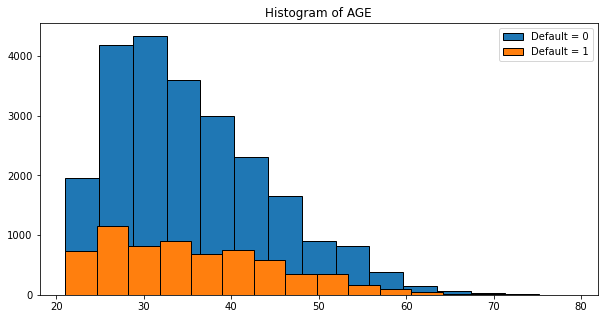

In [43]:
plt.figure(1, figsize=(10,5))

plt.title('Histogram of AGE')
plt.hist(age_0, bins=15, edgecolor='k', label='Default = 0')
plt.hist(age_1, bins=15, edgecolor='k', label='Default = 1')
plt.legend()

Молодые люди 20-25 лет наиболее склонны к невозврату кредита.

In [44]:
print('Median AGE for default = 0: %.0f' % age_0.median())
print('Median AGE for default = 1: %.0f' % age_1.median())

Median AGE for default = 0: 34
Median AGE for default = 1: 34


### Интервальная оценка медианы c помощью бутстрепа

In [45]:
np.random.seed(0)

age0_median_scores = list(map(np.median, get_bootstrap_samples(age_0.values, 1000)))
age1_median_scores = list(map(np.median, get_bootstrap_samples(age_1.values, 1000)))

print("95% confidence interval for age with default = 1:",  stat_intervals(age0_median_scores, 0.05))
print("95% confidence interval for age with default = 0:",  stat_intervals(age1_median_scores, 0.05))

95% confidence interval for age with default = 1: [34. 34.]
95% confidence interval for age with default = 0: [34. 35.]


Проверим гипотезу о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних.

Для проверки гипотезы подойдёт перестановочный критерий для независимых выборок.

-   H0: распределения выборок полностью равны
-   H1: распределения выборок отличаются на величину сдвига

In [55]:
print ("p-value:", permutation_test(age_0, age_1, max_permutations = 1000))

p-value: 0.014


### Ранговый критерий Манна-Уитни

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [47]:
stats.mannwhitneyu(age_0, age_1)

MannwhitneyuResult(statistic=76966879.5, pvalue=0.1862517717449308)

P-value получается довольно маленьким и нулевая гипотеза отвергается на уровне значимости 0.05.